In [1]:
import os
import pandas as pd
from bs4 import BeautifulSoup
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import StringIO

# for interactive plots
import plotly.graph_objects as go

pd.options.display.max_columns = 50

# Get html files to parse
- note this assumes they're in a directory `data/transits_2025.02.17_100_days`, adjust as needed
- adjust the `output_dir` as needed below as well

In [2]:
file_dir = 'data/transits_2025.02.17_100_days'
files = [f for f in os.listdir(file_dir) if 'Observatory' in f]
print(f'found {len(files)} files')

found 7 files


In [3]:
output_dir = 'data/'

# Parse transit data from html

In [4]:
def parse_timing_cell(cell):
    """Parse a single timing cell containing date, time, Alt, Azi, and HA"""
    text = cell.get_text(separator='|', strip=True)
    parts = text.split('|')
    
    # Extract date and time
    date_str = parts[0]
    time_str = parts[1]
    datetime_str = f"{date_str} {time_str}"
    timestamp = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M')
    
    # Extract Alt, Azi, and HA
    alt = float(re.search(r'Alt: (\d+)°', text).group(1))
    azi_match = re.search(r'Azi: (\d+)° \((.*?)\)', text)
    azi_deg = float(azi_match.group(1))
    azi_dir = azi_match.group(2)
    ha = float(re.search(r'HA: ([\d.]+)h', text).group(1))
    
    return {
        'timestamp': timestamp,
        'alt': alt,
        'azi_deg': azi_deg,
        'azi_dir': azi_dir,
        'ha': ha
    }

def parse_observation_timings(notes_table):
    """Parse the nested table containing observation timing data"""
    timing_rows = notes_table.find_all('tr')
    
    # Initialize timing data
    timing_data = {
        'optimal_target_note': '',
        'drifting_ephemeris_note': '',
        'meridian_crossing': None,
        'max_counts_r': None,
        'max_counts_v': None,
        'moon_illumination': None,
        'moon_distance': None
    }
    
    # Find the row with the timing cells (usually first or second row)
    timing_row = None
    for row in timing_rows:
        if len(row.find_all('td')) == 5:  # This is our timing row
            timing_row = row
            break
    
    if not timing_row:
        return timing_data
    
    # Parse each timing column
    timing_cells = timing_row.find_all('td')
    timing_types = ['before_ingress', 'transit_start', 'mid_transit', 'transit_end', 'after_egress']
    
    for timing_type, cell in zip(timing_types, timing_cells):
        cell_data = parse_timing_cell(cell)
        for key, value in cell_data.items():
            timing_data[f'{timing_type}_{key}'] = value
    
    # Look for special notes in first row
    first_row = timing_rows[0]
    if len(timing_rows) > 2 and len(first_row.find_all('td')) == 1:  # Special note present
        note_text = first_row.get_text(strip=True)
        if 'OPTIMAL TARGET NOTE' in note_text:
            timing_data['optimal_target_note'] = note_text
        elif 'DRIFTING EPHEMERIS NOTE' in note_text:
            timing_data['drifting_ephemeris_note'] = note_text
    
    # Parse the last row for additional metadata
    last_row = timing_rows[-1]
    last_row_text = last_row.get_text()
    
    # Extract meridian crossing
    meridian_match = re.search(r'Meridian crossing at: ([\d/: ]+)', last_row_text)
    if meridian_match:
        timing_data['meridian_crossing'] = datetime.strptime(
            meridian_match.group(1), '%Y/%m/%d %H:%M'
        )
    
    # Extract max counts
    max_counts_match = re.search(r'Max counts.*R:(\d+)%.*V:(\d+)%', last_row_text)
    if max_counts_match:
        timing_data['max_counts_r'] = int(max_counts_match.group(1))
        timing_data['max_counts_v'] = int(max_counts_match.group(2))
    
    # Extract moon data
    moon_match = re.search(
        r'Moon illumination: (\d+\.\d+)%, Moon distance: (\d+\.\d+)°',
        last_row_text
    )
    if moon_match:
        timing_data['moon_illumination'] = float(moon_match.group(1))
        timing_data['moon_distance'] = float(moon_match.group(2))
    
    return timing_data

In [5]:
def parse_first_column(col):
    """Parse the first column containing planet name, priority, and observations"""
    # Get planet name from the first font tag
    planet_name = col.find('font').text.strip()
    
    # Get priority from the second font tag
    priority = col.find_all('font')[1].text.strip()
    
    # Split the text by <br /> to get the other fields
    # Convert br tags to a delimiter we can split on
    for br in col.find_all('br'):
        br.replace_with('|')
    
    # Split the text and clean up
    parts = [part.strip() for part in col.text.split('|')]
    
    # Extract min aperture - it's in the format "Min. aperture: X.XX""
    min_aperture = float(parts[1].replace('Min. aperture: ', '').replace('"', ''))
    
    # Extract observations - format "Total Observations (Recent): X (Y)"
    obs_text = parts[2].replace('Total Observations (Recent): ', '')
    total_obs, recent_obs = obs_text.split(' (')
    total_obs = int(total_obs)
    recent_obs = int(recent_obs.rstrip(')'))
    
    # Extract O-C - format "O-C: X.XX ± Y.YY minutes"
    oc_text = parts[3].replace('O-C: ', '').replace(' minutes', '')
    if len(oc_text.strip()) > 1:
        o_c, o_c_uncertainty = map(float, oc_text.split(' ± '))
    else:
        o_c, o_c_uncertainty = (None, None)
    
    return {
        'planet_name': planet_name,
        'priority': priority,
        'min_aperture': min_aperture,
        'total_observations': total_obs,
        'recent_observations': recent_obs,
        'o_c': o_c,
        'o_c_uncertainty': o_c_uncertainty
    }

In [6]:
def parse_exoplanet_table(html_file):
    # Read and parse HTML
    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    
    # Find the main table
    main_table = soup.select_one("div.page-content > div[align=center] > table")
    # print('main_table', main_table)
    
    # tbody = main_table.find('tbody')
    rows = main_table.find_all('tr', recursive=False)[2:]  # Skip first two header rows
    
    data = []
    for row in rows:
        # Get only direct child td elements
        # This gives us our three main columns
        cols = row.find_all('td', recursive=False)
        if len(cols) != 3:  # Skip malformed rows
            continue
            
        # First column parsing (planet info)
        try:
            planet_metadata = parse_first_column(cols[0])
        except Exception as e:
            print(cols[0])
            raise Exception(f'failed with excpeton: {e}')

        # Second column parsing (coordinates and properties)
        ra = re.search(r'RA: ([\d.:]+)', cols[1].text).group(1)
        dec = re.search(r'DEC: ([+-][\d.:]+)', cols[1].text).group(1)
        mag_r = float(re.search(r'Mag(?:R|_R): ([\d.]+)', cols[1].text).group(1))
        depth_r = float(re.search(r'Depth(?:R|_R): ([\d.]+)', cols[1].text).group(1))
        duration = float(re.search(r'Duration: ([\d.]+)', cols[1].text).group(1))
        
        # Third column parsing (notes and additional data)
        notes_col = cols[2]

        # Third column parsing (observation timings and notes)
        notes_table = cols[2].find('table')
        timing_data = parse_observation_timings(notes_table)
        
        # Extract special notes if present
        optimal_note = ''
        if note_elem := notes_col.find(string=re.compile('OPTIMAL TARGET NOTE')):
            optimal_note = note_elem.strip()
            
        drifting_note = ''
        if note_elem := notes_col.find(string=re.compile('DRIFTING EPHEMERIS NOTE')):
            drifting_note = note_elem.strip()
            
        # Extract meridian crossing
        meridian_match = re.search(r'Meridian crossing at: ([\d/: ]+)', notes_col.text)
        meridian_crossing = None
        if meridian_match:
            meridian_crossing = datetime.strptime(meridian_match.group(1), '%Y/%m/%d %H:%M')
            
        # Extract max counts
        max_counts_match = re.search(r'Max counts.*R:(\d+)%.*V:(\d+)%', notes_col.text)
        max_counts_r = max_counts_v = None
        if max_counts_match:
            max_counts_r, max_counts_v = map(int, max_counts_match.groups())
            
        # Extract moon data
        moon_match = re.search(r'Moon illumination: (\d+\.\d+)%, Moon distance: (\d+\.\d+)°', notes_col.text)
        moon_illumination = moon_distance = None
        if moon_match:
            moon_illumination, moon_distance = map(float, moon_match.groups())
        
        # Compile row data
        row_data = planet_metadata
        row_data.update({
            'ra': ra,
            'dec': dec,
            'mag_r': mag_r,
            'depth_r': depth_r,
            'duration': duration,
            'optimal_target_note': optimal_note,
            'drifting_ephemeris_note': drifting_note,
            'meridian_crossing': meridian_crossing,
            'max_counts_r': max_counts_r,
            'max_counts_v': max_counts_v,
            'moon_illumination': moon_illumination,
            'moon_distance': moon_distance
        })

        # Update row_data with timing information
        row_data.update(timing_data)
        data.append(row_data)
    
    return pd.DataFrame(data)

In [7]:
start_date = '2025-03-15'
end_date = '2025-05-15'

# expects pandas.Series as input
datetime_mask_func = lambda x: (x >= pd.to_datetime(start_date + ' 00:00:00')) & (x <= pd.to_datetime(end_date + ' 23:59:59'))
duration_mask_func = lambda x: (x <= 6.0)

df_transits = pd.DataFrame()
# file = files[0]
for file in files:
    observatory_name = file.replace('.html', '').replace(' ', '_').lower()
    file_path = os.path.join(file_dir, file)
    print(f'parsing: {file_path} for observatory: {observatory_name}')
    _df = parse_exoplanet_table(file_path)
    _df['observatory'] = observatory_name
    df_filtered = _df[datetime_mask_func(_df['after_egress_timestamp']) & duration_mask_func(_df['duration'])]
    df_transits = pd.concat([df_transits, df_filtered])

parsing: data/transits_2025.02.17_100_days/Siding Spring Observatory.html for observatory: siding_spring_observatory
parsing: data/transits_2025.02.17_100_days/Cerro Tololo Observatory.html for observatory: cerro_tololo_observatory
parsing: data/transits_2025.02.17_100_days/Nostos Observatory.html for observatory: nostos_observatory
parsing: data/transits_2025.02.17_100_days/Haleakala Observatory.html for observatory: haleakala_observatory
parsing: data/transits_2025.02.17_100_days/Sutherland Observatory.html for observatory: sutherland_observatory
parsing: data/transits_2025.02.17_100_days/McDonald Observatory.html for observatory: mcdonald_observatory
parsing: data/transits_2025.02.17_100_days/Teide Observatory.html for observatory: teide_observatory


In [8]:
df_transits.shape

(2834, 45)

In [9]:
df_transits['planet_name'].unique().shape

(252,)

In [10]:
df_transits['priority'].value_counts()

priority
LOW         1802
MEDIUM       604
HIGH         252
ALERT         86
TTVs          72
CAMPAIGN      18
Name: count, dtype: int64

In [11]:
# normalized planet name
df_transits['normalized_planet_name'] = df_transits['planet_name'].str.replace(' ', '').str.replace('-', '').str.lower()

In [12]:
start_date_fmt = start_date.replace('-', '.')
end_date_fmt = end_date.replace('-', '.')
file_path = f"{output_dir}observable_transits_{start_date_fmt}_{end_date_fmt}.csv"
print(f'saving file: {file_path}')
df_transits.to_csv(file_path, index=False)

saving file: data/observable_transits_2025.03.15_2025.05.15.csv


In [14]:
# just checking it generated a valid csv
check = pd.read_csv(f"{output_dir}observable_transits_{start_date_fmt}_{end_date_fmt}.csv")
del check

# Query planets
- main site: https://exoplanetarchive.ipac.caltech.edu/
- desc of columns: https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html
- table explorer: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS
- the function below basically just uses sql, planet names are normalized to only lower case alphanumeric characters

### alternatives
- open catalogue: https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue
- compressed data (updated automatically every 24 hours): https://github.com/OpenExoplanetCatalogue/oec_gzip

In [15]:
def get_planet_params(planet_names):
    """
    Query the NASA Exoplanet Archive for planetary parameters
    Args:
        planet_names: List of planet names or single planet name string
    """
    if isinstance(planet_names, str):
        planet_names = [planet_names]
    
    normalized_names = ["'" + name.lower().replace(' ', '').replace('-', '') + "'" for name in planet_names]
    names_str = ','.join(normalized_names)
    
    base_url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"
    
    # see https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html for desc of columns
    query = f"""
    SELECT pl_name, hostname, pl_orbper, pl_orbsmax, pl_radj, pl_bmassj, 
           pl_dens, pl_eqt, pl_ratror, pl_orbeccen, pl_insol, 
           pl_orbincl, pl_orblper, pl_imppar, pl_ratdor, 
           st_teff, st_rad, st_mass, st_met, st_metratio, st_lum, st_age, st_dens
           sy_dist, sy_snum, sy_pnum, sy_mnum, cb_flag,
           disc_year, disc_facility,
           rowupdate, releasedate, st_nphot, st_nspec, pl_ndispec
    FROM ps 
    WHERE REPLACE(REPLACE(LOWER(pl_name), ' ', ''), '-', '') 
          IN ({names_str})
    AND default_flag = 1
    """
    
    try:
        response = requests.get(base_url, params={'query': query, 'format': 'csv'})
        response.raise_for_status()
        
        # parse response to csv (is this the best way to do that??)
        df = pd.read_csv(StringIO(response.text))
        
        if df.empty:
            print(f"No data found for planets: {', '.join(planet_names)}")
            return None
            
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"Error making request: {e}")
        return None
    except pd.errors.EmptyDataError:
        print(f"No data found for planets: {', '.join(planet_names)}")
        return None

### Example querying one planet

In [16]:
planets = ["GJ436b"] # 'HAT-P-44b'
df_planets = get_planet_params(planets)
print("\nSingle planet query:")
df_planets.head()


Single planet query:


,pl_name,hostname,pl_orbper,pl_orbsmax,pl_radj,pl_bmassj,pl_dens,pl_eqt,pl_ratror,pl_orbeccen,pl_insol,pl_orbincl,pl_orblper,pl_imppar,pl_ratdor,st_teff,st_rad,st_mass,st_met,st_metratio,st_lum,st_age,sy_dist,sy_snum,sy_pnum,sy_mnum,cb_flag,disc_year,disc_facility,rowupdate,releasedate,st_nphot,st_nspec,pl_ndispec
0,GJ 436 b,GJ 436,2.643883,0.0291,0.372,0.07,1.8,NaN,0.0822,0.13827,NaN,86.44,351.0,0.736,13.73,NaN,0.46,0.47,NaN,NaN,NaN,NaN,7.0,1,1,0,0,2004,W. M. Keck Observatory,2015-02-05,2015-02-05,60,4,0


### Query unique planets from observable transits

In [17]:
planet_names = df_transits['planet_name'].unique().tolist()
print(f'found {len(planet_names)} unique planets from {df_transits.shape[0]} potential observable transits')

found 252 unique planets from 2834 potential observable transits


In [18]:
df_planets = get_planet_params(planet_names)
print(f'successfully queried {df_planets.shape[0]} planets\n')
df_planets.head()

successfully queried 252 planets



,pl_name,hostname,pl_orbper,pl_orbsmax,pl_radj,pl_bmassj,pl_dens,pl_eqt,pl_ratror,pl_orbeccen,pl_insol,pl_orbincl,pl_orblper,pl_imppar,pl_ratdor,st_teff,st_rad,st_mass,st_met,st_metratio,st_lum,st_age,sy_dist,sy_snum,sy_pnum,sy_mnum,cb_flag,disc_year,disc_facility,rowupdate,releasedate,st_nphot,st_nspec,pl_ndispec
0,CoRoT-11 b,CoRoT-11,2.994330,0.04360,1.430,2.33000,0.9900,1657.0,0.10700,0.00000,NaN,83.17,NaN,0.818,6.89,6440.0,1.37,1.27,-0.03,[Fe/H],NaN,2.0,0.690,1,1,0,0,2010,CoRoT,2014-05-14,2014-05-14,0,0,0
1,CoRoT-2 b,CoRoT-2,1.742994,0.02798,1.466,3.47000,1.4700,NaN,NaN,0.01430,NaN,88.08,102.0,0.221,NaN,5625.0,0.91,0.96,NaN,NaN,NaN,2.7,1.814,2,1,0,0,2008,CoRoT,2014-05-14,2014-05-14,20,0,0
2,GJ 1214 b,GJ 1214,1.580405,0.01505,0.244,0.02646,2.2600,567.0,0.11589,0.00620,17.2,88.98,77.0,0.264,14.97,3101.0,0.22,0.18,0.24,[Fe/H],-2.409,NaN,25.410,1,1,0,0,2009,MEarth Project,2024-03-25,2024-03-25,0,2,0
3,GJ 436 b,GJ 436,2.643883,0.02910,0.372,0.07000,1.8000,NaN,0.08220,0.13827,NaN,86.44,351.0,0.736,13.73,NaN,0.46,0.47,NaN,NaN,NaN,NaN,7.000,1,1,0,0,2004,W. M. Keck Observatory,2015-02-05,2015-02-05,60,4,0
4,HAT-P-12 b,HAT-P-12,3.213060,0.03840,0.959,0.21100,0.3192,963.0,0.14060,0.00000,NaN,89.00,NaN,0.211,11.77,4650.0,0.70,0.73,-0.29,[Fe/H],-0.678,2.5,NaN,1,1,0,0,2009,HATNet,2014-05-14,2014-05-14,7,0,0


In [19]:
# normalized planet names for joining with transit data
df_planets['normalized_planet_name'] = df_planets['pl_name'].str.replace(' ', '').str.replace('-', '').str.lower()

In [89]:
df_planets.columns

Index(['pl_name', 'hostname', 'pl_orbper', 'pl_orbsmax', 'pl_radj',
       'pl_bmassj', 'pl_dens', 'pl_eqt', 'pl_ratror', 'pl_orbeccen',
       'pl_insol', 'pl_orbincl', 'pl_orblper', 'pl_imppar', 'pl_ratdor',
       'st_teff', 'st_rad', 'st_mass', 'st_met', 'st_metratio', 'st_lum',
       'st_age', 'sy_dist', 'sy_snum', 'sy_pnum', 'sy_mnum', 'cb_flag',
       'disc_year', 'disc_facility', 'rowupdate', 'releasedate', 'st_nphot',
       'st_nspec', 'pl_ndispec', 'normalized_planet_name'],
      dtype='object')

In [21]:
file_path = f'{output_dir}planet_params.csv'
print(f'saving planet parameters to: {file_path}')
df_planets.to_csv(file_path, index=False)

saving planet parameters to: data/planet_params.csv


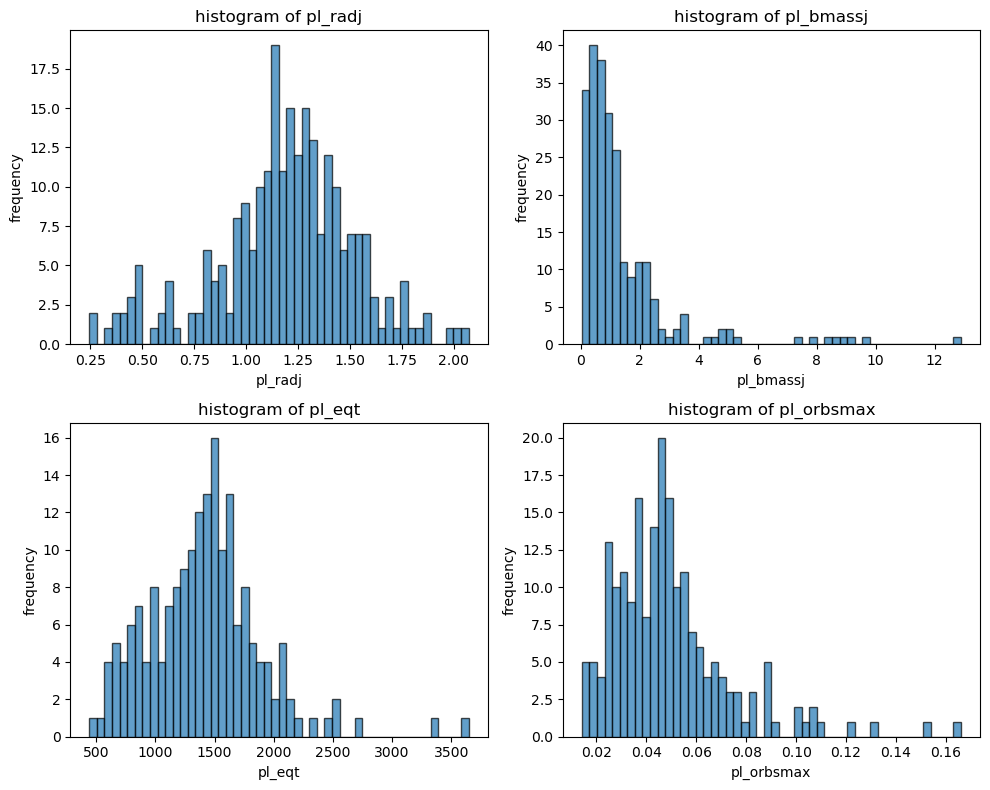

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten() # for ease of use

columns = ['pl_radj', 'pl_bmassj', 'pl_eqt', 'pl_orbsmax'] # 'pl_dens'
bins = 50

for ax, col in zip(axes, columns):
    ax.hist(df_planets[col], bins=bins, alpha=0.7, color='tab:blue', edgecolor='black')
    ax.set_title(f'histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('frequency')

plt.tight_layout()
plt.show()

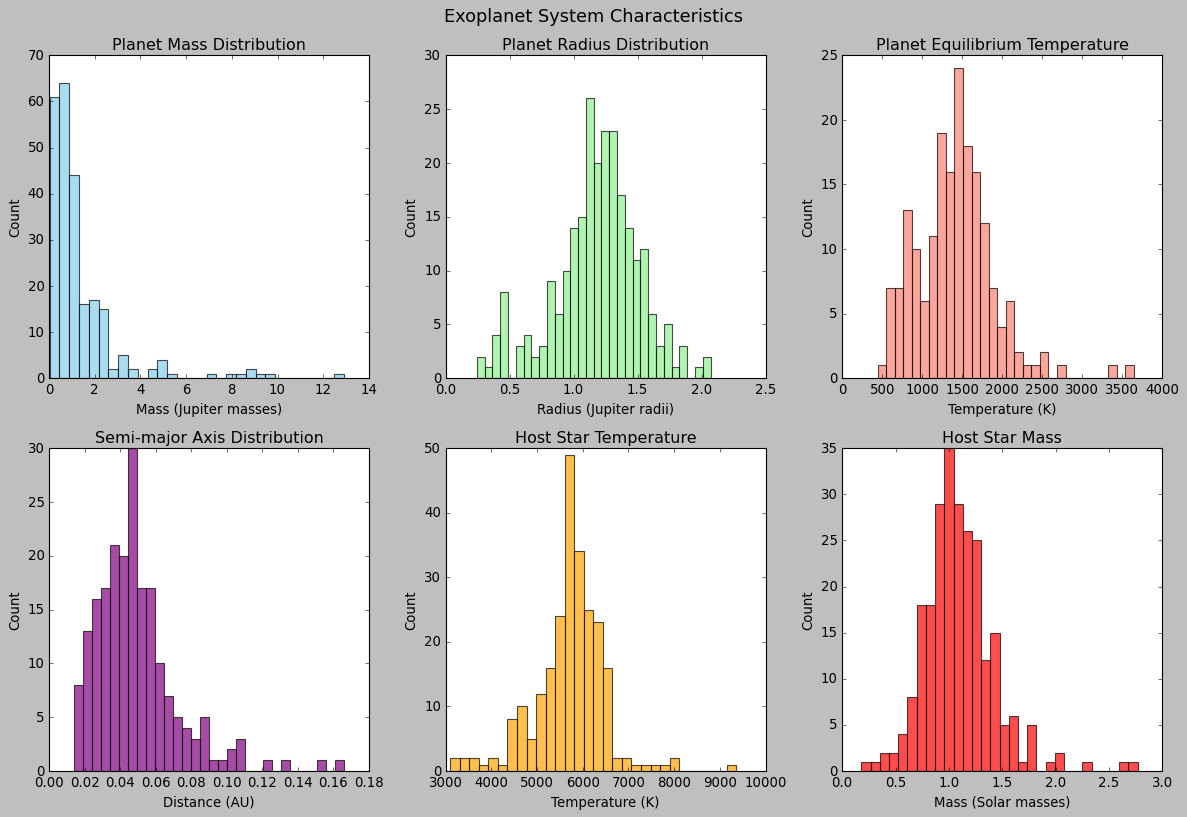

In [23]:
# Set style for better-looking plots
plt.style.use('classic')

# Create figure and subplots - 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot 1: Planet Mass (in Jupiter masses)
axes[0].hist(df_planets['pl_bmassj'].dropna(), bins=30, color='skyblue', alpha=0.7)
axes[0].set_title('Planet Mass Distribution')
axes[0].set_xlabel('Mass (Jupiter masses)')
axes[0].set_ylabel('Count')

# Plot 2: Planet Radius (in Jupiter radii)
axes[1].hist(df_planets['pl_radj'].dropna(), bins=30, color='lightgreen', alpha=0.7)
axes[1].set_title('Planet Radius Distribution')
axes[1].set_xlabel('Radius (Jupiter radii)')
axes[1].set_ylabel('Count')

# Plot 3: Planet Equilibrium Temperature
axes[2].hist(df_planets['pl_eqt'].dropna(), bins=30, color='salmon', alpha=0.7)
axes[2].set_title('Planet Equilibrium Temperature')
axes[2].set_xlabel('Temperature (K)')
axes[2].set_ylabel('Count')

# Plot 4: Semi-major Axis (distance from star)
axes[3].hist(df_planets['pl_orbsmax'].dropna(), bins=30, color='purple', alpha=0.7)
axes[3].set_title('Semi-major Axis Distribution')
axes[3].set_xlabel('Distance (AU)')
axes[3].set_ylabel('Count')

# Plot 5: Stellar Temperature
axes[4].hist(df_planets['st_teff'].dropna(), bins=30, color='orange', alpha=0.7)
axes[4].set_title('Host Star Temperature')
axes[4].set_xlabel('Temperature (K)')
axes[4].set_ylabel('Count')

# Plot 6: Stellar Mass
axes[5].hist(df_planets['st_mass'].dropna(), bins=30, color='red', alpha=0.7)
axes[5].set_title('Host Star Mass')
axes[5].set_xlabel('Mass (Solar masses)')
axes[5].set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a main title
fig.suptitle('Exoplanet System Characteristics', y=1.02, fontsize=16)


# Save the figure with high DPI for quality
plt.savefig(f'{output_dir}exoplanet_param_distributions.pdf', 
            dpi=300,  # High resolution
            bbox_inches='tight',  # Includes the full figure with titles
            pad_inches=0.1)  # Slight padding around the plots

# Display the plot (optional)
plt.show()

### Get priority and duration of each observable transit
- can grab extra columns as needed

In [33]:
df_transits.head()

,planet_name,priority,min_aperture,total_observations,recent_observations,o_c,o_c_uncertainty,ra,dec,mag_r,depth_r,duration,optimal_target_note,drifting_ephemeris_note,meridian_crossing,max_counts_r,max_counts_v,moon_illumination,moon_distance,before_ingress_timestamp,before_ingress_alt,before_ingress_azi_deg,before_ingress_azi_dir,before_ingress_ha,transit_start_timestamp,transit_start_alt,transit_start_azi_deg,transit_start_azi_dir,transit_start_ha,mid_transit_timestamp,mid_transit_alt,mid_transit_azi_deg,mid_transit_azi_dir,mid_transit_ha,transit_end_timestamp,transit_end_alt,transit_end_azi_deg,transit_end_azi_dir,transit_end_ha,after_egress_timestamp,after_egress_alt,after_egress_azi_deg,after_egress_azi_dir,after_egress_ha,observatory,normalized_planet_name
198,HATS-42b,MEDIUM,10.36,30,2,1.950,0.880,07:13:48.5748,-33:26:14.401,13.610,11.96,3.29,,,2025-03-15 09:42:00,0,0,98.7,78.1,2025-03-15 09:02:00,81.0,106.0,E,23.30,2025-03-15 10:02:00,86.0,239.0,SW,0.30,2025-03-15 11:41:00,65.0,257.0,W,1.95,2025-03-15 13:20:00,45.0,252.0,W,3.60,2025-03-15 14:20:00,33.0,248.0,W,4.60,siding_spring_observatory,hats42b
199,WASP-19b,TTVs,5.92,175,25,-0.824,0.083,09:53:40.0764,-45:39:33.055,12.120,22.96,1.66,,,2025-03-15 12:25:00,1,2,98.6,53.4,2025-03-15 10:12:00,61.0,129.0,SE,21.80,2025-03-15 11:12:00,70.0,141.0,SE,22.80,2025-03-15 12:02:00,75.0,165.0,S,23.63,2025-03-15 12:52:00,75.0,199.0,S,0.47,2025-03-15 13:52:00,68.0,224.0,SW,1.47,siding_spring_observatory,wasp19b
200,K2-19b,TTVs,12.53,19,0,-42.460,2.880,11:39:50.4804,+00:36:12.877,12.880,7.63,3.27,,DRIFTING EPHEMERIS NOTE: a drift of -42.46 min...,2025-03-15 14:07:00,5,10,98.5,13.8,2025-03-15 11:03:00,36.0,63.0,NE,20.89,2025-03-15 12:03:00,46.0,49.0,NE,21.89,2025-03-15 13:42:00,57.0,13.0,N,23.53,2025-03-15 15:20:00,54.0,329.0,NW,1.17,2025-03-15 16:20:00,46.0,310.0,NW,2.17,siding_spring_observatory,k219b
201,NGTS-24b,MEDIUM,15.83,4,2,-2.930,2.560,11:14:15.3343,-37:54:36.486,12.817,6.03,2.94,OPTIMAL TARGET NOTE: this planet cannot be obs...,,2025-03-15 13:45:00,1,3,98.5,37.7,2025-03-15 11:24:00,61.0,113.0,SE,21.67,2025-03-15 12:24:00,72.0,118.0,SE,22.67,2025-03-15 13:53:00,83.0,194.0,S,0.14,2025-03-15 15:21:00,69.0,245.0,SW,1.62,2025-03-15 16:21:00,57.0,247.0,SW,2.62,siding_spring_observatory,ngts24b
202,HATS-31b,MEDIUM,9.75,8,2,1.280,1.460,12:46:48.6784,-24:25:38.568,13.200,10.34,4.64,,,2025-03-15 15:15:00,1,3,98.2,19.4,2025-03-15 13:09:00,61.0,84.0,E,21.87,2025-03-15 14:09:00,74.0,70.0,E,22.87,2025-03-15 16:28:00,73.0,289.0,W,1.20,2025-03-15 18:47:00,43.0,265.0,W,3.52,2025-03-15 19:47:00,31.0,258.0,W,4.53,siding_spring_observatory,hats31b


In [90]:
agg = {
    'priority': ['max'],
    'total_observations': ['max'],
    'recent_observations': ['max'],
    'o_c': ['max'],
    'observatory': ['max'],
    'duration': ['median', 'count']
}
df_transits_of_interest = df_transits.groupby(['planet_name', 'normalized_planet_name']).agg(agg)
df_transits_of_interest = df_transits_of_interest.reset_index()

# handle column names
clean_col = lambda c1, c2: c1 + ('_' + c2 if len(c2) > 0 else '')
df_transits_of_interest.columns = [clean_col(c[0], c[1]).replace('_max', '')  for c in df_transits_of_interest.columns]
col_map = {'priority_max': 'priority', 'duration_median': 'duration', 'duration_count': 'observable_transits'}
df_transits_of_interest = df_transits_of_interest.rename(col_map, axis=1)

df_transits_of_interest.head()

,planet_name,normalized_planet_name,priority,total_observations,recent_observations,o_c,observatory,duration,observable_transits
0,CoRoT-11b,corot11b,LOW,45,15,-1.61,cerro_tololo_observatory,2.49,11
1,CoRoT-2b,corot2b,LOW,79,21,0.69,teide_observatory,2.28,5
2,GJ1214b,gj1214b,LOW,98,6,0.11,teide_observatory,0.87,43
3,GJ3470b,gj3470b,LOW,65,3,-1.57,teide_observatory,1.91,5
4,GJ436b,gj436b,MEDIUM,86,3,0.62,teide_observatory,0.99,31


In [91]:
df_planets_with_priority = df_planets.merge(df_transits_of_interest, on='normalized_planet_name')
df_planets_with_priority.head()

,pl_name,hostname,pl_orbper,pl_orbsmax,pl_radj,pl_bmassj,pl_dens,pl_eqt,pl_ratror,pl_orbeccen,pl_insol,pl_orbincl,pl_orblper,pl_imppar,pl_ratdor,st_teff,st_rad,st_mass,st_met,st_metratio,st_lum,st_age,sy_dist,sy_snum,sy_pnum,sy_mnum,cb_flag,disc_year,disc_facility,rowupdate,releasedate,st_nphot,st_nspec,pl_ndispec,normalized_planet_name,planet_name,priority,total_observations,recent_observations,o_c,observatory,duration,observable_transits
0,CoRoT-11 b,CoRoT-11,2.994330,0.04360,1.430,2.33000,0.9900,1657.0,0.10700,0.00000,NaN,83.17,NaN,0.818,6.89,6440.0,1.37,1.27,-0.03,[Fe/H],NaN,2.0,0.690,1,1,0,0,2010,CoRoT,2014-05-14,2014-05-14,0,0,0,corot11b,CoRoT-11b,LOW,45,15,-1.61,cerro_tololo_observatory,2.49,11
1,CoRoT-2 b,CoRoT-2,1.742994,0.02798,1.466,3.47000,1.4700,NaN,NaN,0.01430,NaN,88.08,102.0,0.221,NaN,5625.0,0.91,0.96,NaN,NaN,NaN,2.7,1.814,2,1,0,0,2008,CoRoT,2014-05-14,2014-05-14,20,0,0,corot2b,CoRoT-2b,LOW,79,21,0.69,teide_observatory,2.28,5
2,GJ 1214 b,GJ 1214,1.580405,0.01505,0.244,0.02646,2.2600,567.0,0.11589,0.00620,17.2,88.98,77.0,0.264,14.97,3101.0,0.22,0.18,0.24,[Fe/H],-2.409,NaN,25.410,1,1,0,0,2009,MEarth Project,2024-03-25,2024-03-25,0,2,0,gj1214b,GJ1214b,LOW,98,6,0.11,teide_observatory,0.87,43
3,GJ 436 b,GJ 436,2.643883,0.02910,0.372,0.07000,1.8000,NaN,0.08220,0.13827,NaN,86.44,351.0,0.736,13.73,NaN,0.46,0.47,NaN,NaN,NaN,NaN,7.000,1,1,0,0,2004,W. M. Keck Observatory,2015-02-05,2015-02-05,60,4,0,gj436b,GJ436b,MEDIUM,86,3,0.62,teide_observatory,0.99,31
4,HAT-P-12 b,HAT-P-12,3.213060,0.03840,0.959,0.21100,0.3192,963.0,0.14060,0.00000,NaN,89.00,NaN,0.211,11.77,4650.0,0.70,0.73,-0.29,[Fe/H],-0.678,2.5,NaN,1,1,0,0,2009,HATNet,2014-05-14,2014-05-14,7,0,0,hatp12b,HAT-P-12b,LOW,161,15,1.04,teide_observatory,2.34,21


In [62]:
df_planets_with_priority['priority'].value_counts()

priority
LOW         122
MEDIUM       61
HIGH         47
ALERT        16
TTVs          5
CAMPAIGN      1
Name: count, dtype: int64

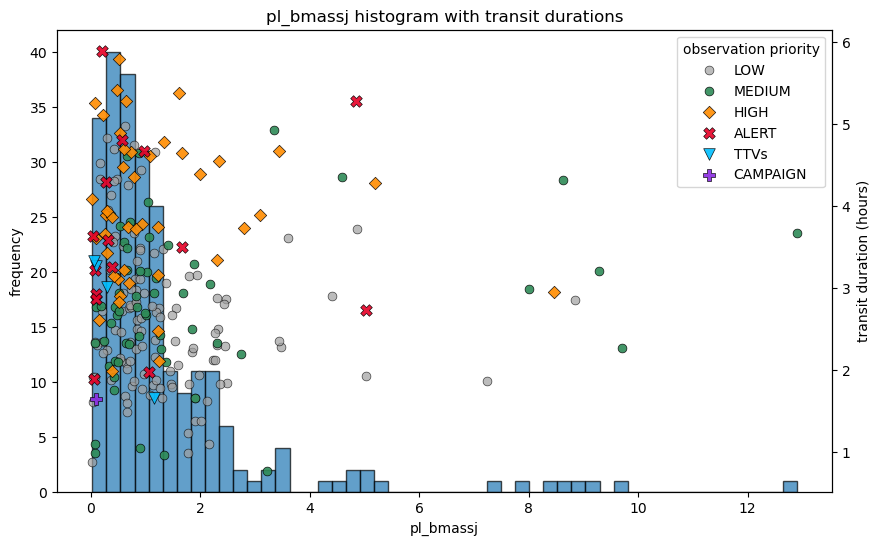

In [92]:
plt.style.use('default')

priority_colors = {
    'LOW': 'tab:gray', 
    'MEDIUM': 'tab:green', 
    'HIGH': 'tab:orange',
    'ALERT': 'tab:red',
    'TTVs': 'tab:cyan',
    'CAMPAIGN': 'tab:purple',
}
priority_colors = {
    'LOW': '#A0A0A0',        # Soft Gray (neutral)
    'MEDIUM': '#2E8B57',     # Sea Green (calm but noticeable)
    'HIGH': '#FF8C00',       # Dark Orange (stands out)
    'ALERT': '#E60026',      # Bright Red (urgent)
    'TTVs': '#00BFFF',       # Deep Sky Blue (cool and distinct)
    'CAMPAIGN': '#8A2BE2',   # Blue Violet (bold and eye-catching)
}
# priority_colors = {
#     'LOW': '#B0B0B0',       # Light Gray
#     'MEDIUM': '#28A745',    # Vibrant Green
#     'HIGH': '#FF4500',      # Bright Orange-Red
#     'ALERT': '#D00000',     # Deeper Red
#     'TTVs': '#00CFFF',      # Electric Blue
#     'CAMPAIGN': '#9932CC',  # Dark Orchid Purple
# }

# marker ref: https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html#filled-markers
priority_markers = {
    'LOW': 'o',
    'MEDIUM': 'o',
    'HIGH': 'D',
    'ALERT': 'X',
    'TTVs': 'v',
    'CAMPAIGN': 'P'
}

bins = 50

col = 'pl_bmassj'

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(df_planets_with_priority[col], bins=bins, alpha=0.7, color='tab:blue', edgecolor='black')
ax1.set_xlabel(col)
ax1.set_ylabel('frequency')

ax2 = ax1.twinx()
for priority, color in priority_colors.items():
    subset = df_planets_with_priority[df_planets_with_priority['priority'] == priority]
    alpha = 0.7 if priority == 'LOW' else 0.9
    marker = priority_markers[priority]
    marker_size = 40 if priority in ('LOW', 'MEDIUM', 'HIGH') else 70
    ax2.scatter(subset['pl_bmassj'], subset['duration'], label=priority, color=color, 
                alpha=alpha, marker=marker, edgecolors='black', linewidth=0.5, s=marker_size)

ax2.set_ylabel('transit duration (hours)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(title="observation priority", loc='upper right')

plt.title(f'{col} histogram with transit durations')

plt.savefig(f'{output_dir}exoplanets_{col}_with_transit_durations.pdf', 
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.1)

plt.show()

### Put it all together

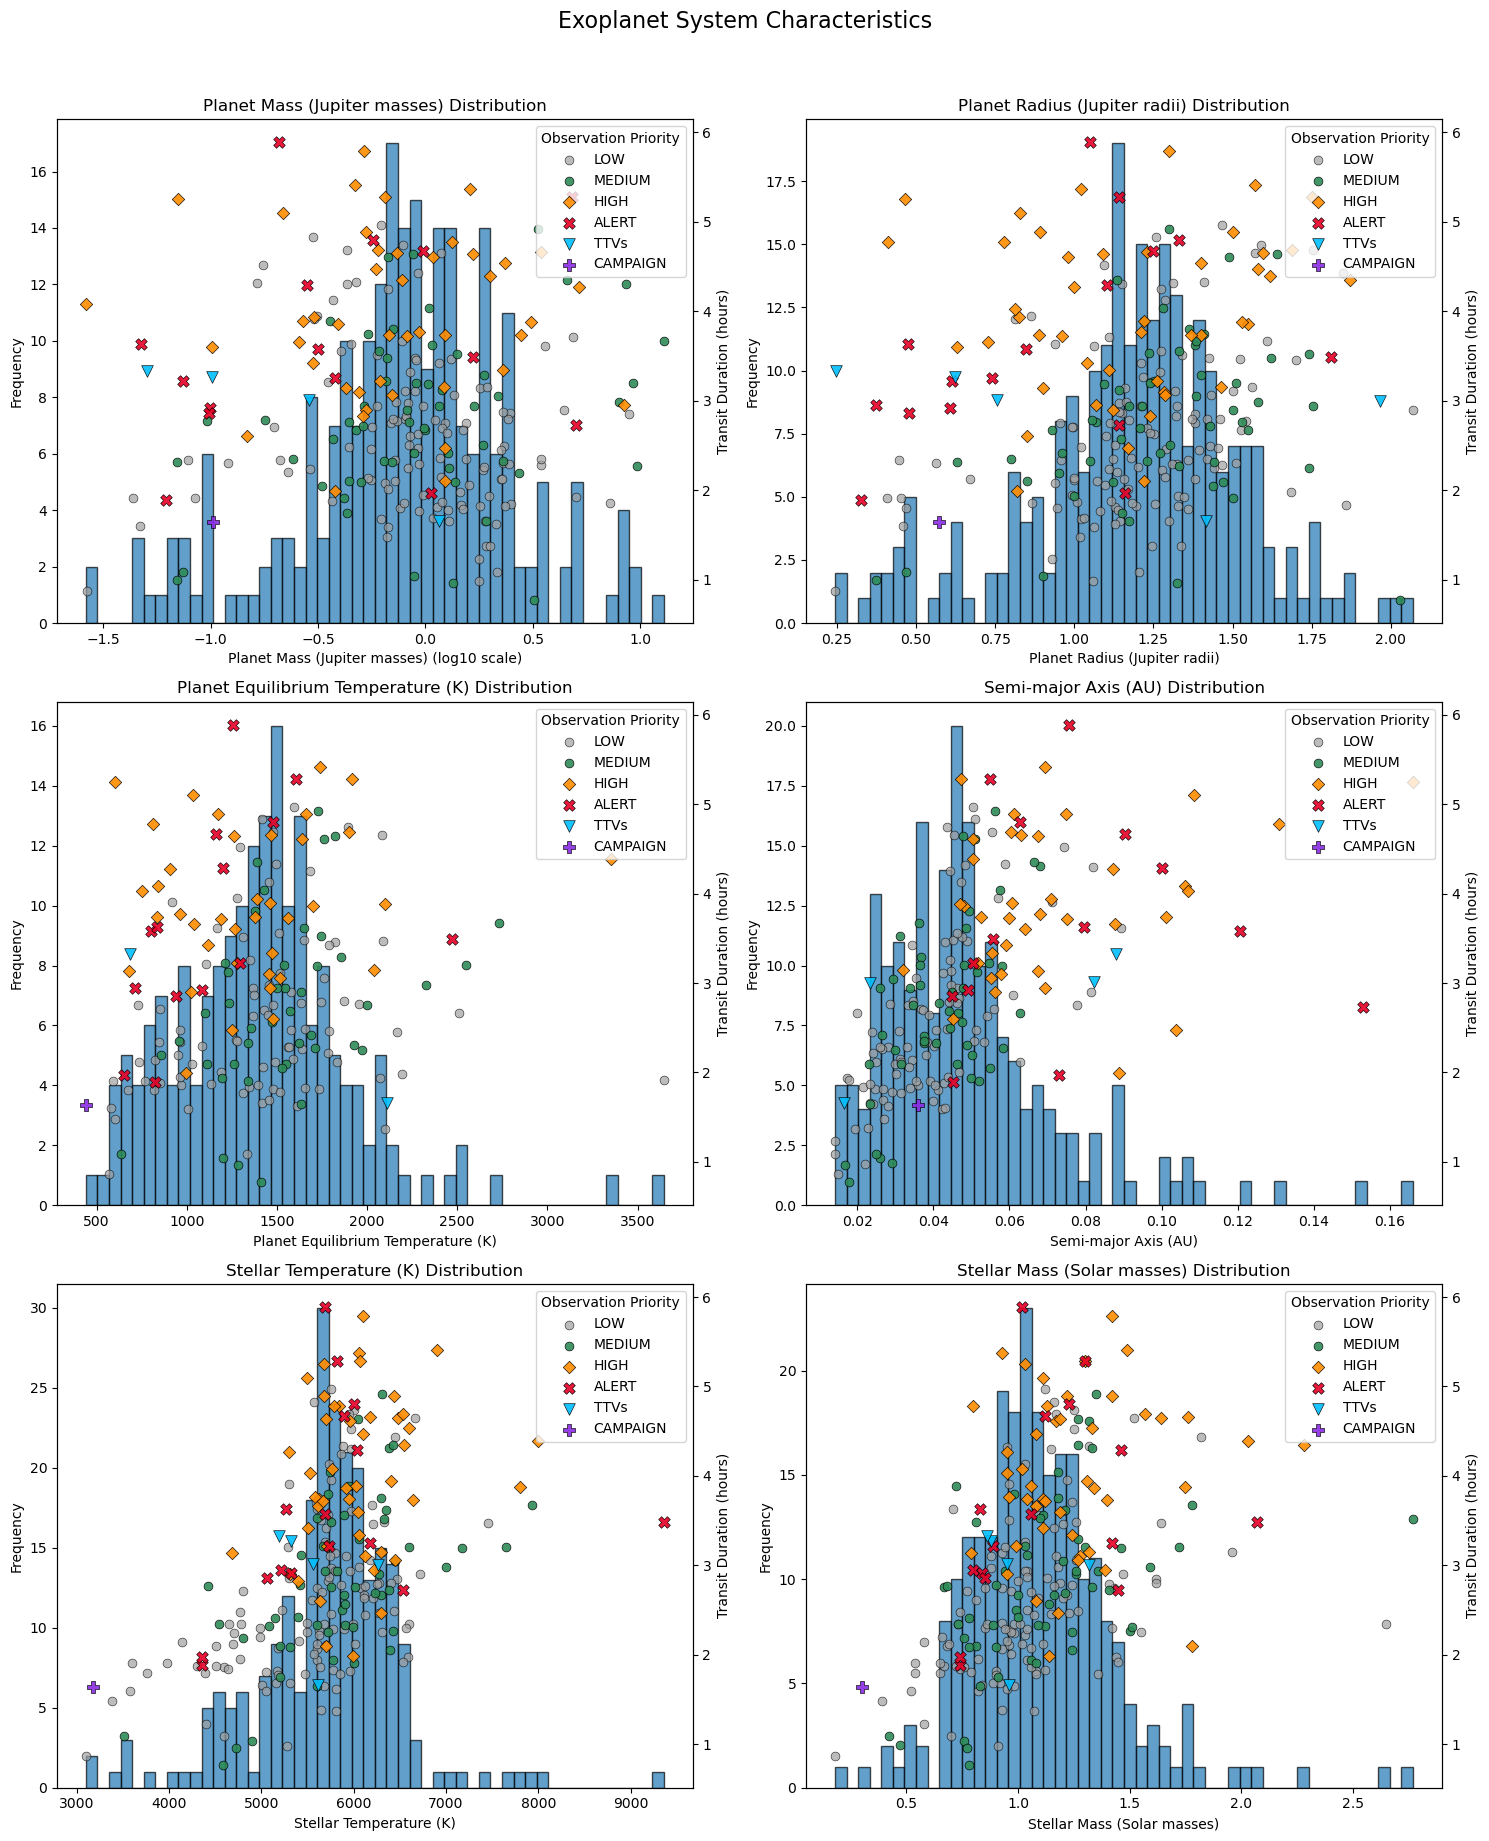

In [100]:
def plot_parameter_histogram(ax1, df, column, priority_colors, priority_markers, friendly_name_map, log_scale=False):
    bins = 50

    apply_scale = lambda x: np.log10(x) if log_scale else x
    # apply_scale = lambda x: x
    ax1.hist(apply_scale(df[column]), bins=bins, alpha=0.7, color='tab:blue', edgecolor='black')
    _extra_fmt = ' (log10 scale)' if log_scale else ''
    ax1.set_xlabel(friendly_name_map[column] + _extra_fmt)
    ax1.set_ylabel('Frequency')
    
    ax2 = ax1.twinx()
    for priority, color in priority_colors.items():
        subset = df[df['priority'] == priority]
        alpha = 0.7 if priority == 'LOW' else 0.9
        marker = priority_markers[priority]
        marker_size = 40 if priority in ('LOW', 'MEDIUM', 'HIGH') else 70
        ax2.scatter(apply_scale(subset[column]), subset['duration'], 
                   label=priority, color=color, 
                   alpha=alpha, marker=marker, 
                   edgecolors='black', linewidth=0.5, s=marker_size)
    
    ax2.set_ylabel('Transit Duration (hours)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(title="Observation Priority", loc='upper right')
    ax1.set_title(f'{friendly_name_map[column]} Distribution')

# Define color and marker styles
priority_colors = {
    'LOW': '#A0A0A0',
    'MEDIUM': '#2E8B57',
    'HIGH': '#FF8C00',
    'ALERT': '#E60026',
    'TTVs': '#00BFFF',
    'CAMPAIGN': '#8A2BE2',
}

priority_markers = {
    'LOW': 'o',
    'MEDIUM': 'o',
    'HIGH': 'D',
    'ALERT': 'X',
    'TTVs': 'v',
    'CAMPAIGN': 'P'
}

plt.style.use('default')

# Create figure with 3x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

# Define columns to plot
columns = ['pl_bmassj', 'pl_radj', 'pl_eqt', 'pl_orbsmax', 'st_teff', 'st_mass']
log_scale = [True, False, False, False, False, False]
friendly_name_map = {
    'pl_bmassj': 'Planet Mass (Jupiter masses)',
    'pl_radj': 'Planet Radius (Jupiter radii)',
    'pl_eqt': 'Planet Equilibrium Temperature (K)',
    'pl_orbsmax': 'Semi-major Axis (AU)',
    'st_teff': 'Stellar Temperature (K)',
    'st_mass': 'Stellar Mass (Solar masses)'
}

# Create plots
for ax, col, do_log_scale in zip(axes, columns, log_scale):
    plot_parameter_histogram(ax, df_planets_with_priority, col, priority_colors, priority_markers, friendly_name_map, log_scale=do_log_scale)

fig.suptitle('Exoplanet System Characteristics', y=1.02, fontsize=16)
plt.tight_layout()

plt.savefig(f'{output_dir}exoplanet_param_distributions_with_transits.pdf', 
            dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

# Let's make it interactive!

In [65]:
def create_interactive_plot(df, initial_column, num_bins=50):
    fig = go.Figure()
    
    # 1. Create initial histogram (this will be trace index 0)
    fig.add_trace(
        go.Histogram(
            x=df[initial_column],
            name='Count',
            opacity=0.7,
            marker_color='rgba(100, 149, 237, 0.7)',
            nbinsx=num_bins
        )
    )
    
    # 2. Add scatter plots for each priority (these will be traces 1 through 6)
    for priority, color in priority_colors.items():
        subset = df[df['priority'] == priority]
        num_rows = subset.shape[0]
        
        marker_symbol = {
            'LOW': 'circle',
            'MEDIUM': 'circle',
            'HIGH': 'diamond',
            'ALERT': 'x',
            'TTVs': 'triangle-down',
            'CAMPAIGN': 'pentagon'
        }[priority]
        
        marker_size = 10 if priority in ('LOW', 'MEDIUM', 'HIGH') else 12
        
        fig.add_trace(
            go.Scatter(
                x=subset[initial_column],
                y=subset['duration'],
                mode='markers',
                name=priority,
                marker=dict(
                    symbol=marker_symbol,
                    size=marker_size,
                    color=color,
                    line=dict(color='black', width=1),
                    opacity=0.7 if priority == 'LOW' else 0.9
                ),
                yaxis='y2',
                hovertemplate=(
                    f"Planet: %{{customdata[0]}}<br>"
                    f"Parameter: %{{x}}<br>"  # Make this generic since it will update
                    f"Duration: %{{y:.1f}} hours<br>"
                    f"Observable Transits: %{{customdata[1]}}<br>"
                    f"Total Obsvs: %{{customdata[2]}}<br>"
                    f"O-C: %{{customdata[3]}}<br>"
                    f"Observatory: %{{customdata[4]}}<br>"
                    "<extra></extra>"
                ),
                customdata=list(zip(subset['planet_name'], 
                                    subset['observable_transits'], 
                                    subset['total_observations'],
                                    subset['o_c'],
                                    subset['observatory']))
            )
        )

    # 3. Get list of numerical columns for dropdown options
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # 4. Create dropdown buttons - one for each numerical column
    buttons = []
    for col in numeric_cols:
        # For each column, we need to update:
        # - The histogram data (trace 0)
        # - The scatter plot data (traces 1-6)
        # - The axis labels and titles
        buttons.append(dict(
            label=col,
            method="update",
            args=[
                # First argument updates the data
                {
                    "x": [df[col]] + [df[df['priority'] == p][col] for p in priority_colors.keys()]
                },
                # Second argument updates the layout
                {
                    "xaxis.title.text": col,  # Fixed: Update x-axis label
                    "title.text": f"{col} Distribution with Transit Durations",
                }
            ]
        ))
    
    # 5. Find which button should be active initially
    initial_active = numeric_cols.index(initial_column)

    # 6. Set up the overall layout
    fig.update_layout(
        title=f'{initial_column} Distribution with Transit Durations',
        xaxis_title=initial_column,  # Initial x-axis title
        yaxis_title='Count',
        yaxis2=dict(
            title='Transit Duration (hours)',
            overlaying='y',
            side='right'
        ),
        showlegend=True,
        legend=dict(
            title='Observation Priority',
            x=1.1, # Position from left (1.0 is right edge of plot)
            y=1.0, # Position from bottom (1.0 is top of plot)
            xanchor='left',
            yanchor='top',
        ),
        hovermode='closest',
        height=600,
        # Add the dropdown menu
        updatemenus=[dict(
            buttons=buttons,
            direction="down",
            showactive=True,
            active=initial_active,
            x=0.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )]
    )
    
    return fig

In [ ]:
_df = df_planets_with_priority #.loc[df_planets_with_priority['observatory'] == 'nostos_observatory']
fig = create_interactive_plot(_df, 'pl_bmassj')
fig.show()

## Proposals
- HAT-P-2 b -> medium priority, multi planet system
    - https://www.exoclock.space/database/planets/HAT-P-2b/
- WASP-148 b -> TTV, multi planet system, high O-C
    - https://www.exoclock.space/database/planets/WASP-148b/
- TOI-1710 b -> high priority
    - https://www.exoclock.space/database/planets/TOI-1710b/
- TOI-1136d
    - https://www.exoclock.space/database/planets/TOI-1136d/

In [83]:
df_transits.loc[df_transits['planet_name'] == 'TOI-1136d']

,planet_name,priority,min_aperture,total_observations,recent_observations,o_c,o_c_uncertainty,ra,dec,mag_r,depth_r,duration,optimal_target_note,drifting_ephemeris_note,meridian_crossing,max_counts_r,max_counts_v,moon_illumination,moon_distance,before_ingress_timestamp,before_ingress_alt,before_ingress_azi_deg,before_ingress_azi_dir,before_ingress_ha,transit_start_timestamp,transit_start_alt,transit_start_azi_deg,transit_start_azi_dir,transit_start_ha,mid_transit_timestamp,mid_transit_alt,mid_transit_azi_deg,mid_transit_azi_dir,mid_transit_ha,transit_end_timestamp,transit_end_alt,transit_end_azi_deg,transit_end_azi_dir,transit_end_ha,after_egress_timestamp,after_egress_alt,after_egress_azi_deg,after_egress_azi_dir,after_egress_ha,observatory,normalized_planet_name
460,TOI-1136d,HIGH,14.32,1,0,1.67,5.76,12:48:44.3726,+64:51:19.147,9.147,2.51,4.08,OPTIMAL TARGET NOTE: this planet cannot be obs...,,2025-05-06 08:13:00,3,6,67.5,58.8,2025-05-06 05:02:00,36.0,23.0,NE,20.77,2025-05-06 06:02:00,41.0,18.0,N,21.78,2025-05-06 08:05:00,46.0,2.0,N,23.82,2025-05-06 10:07:00,42.0,344.0,N,1.87,2025-05-06 11:07:00,38.0,339.0,N,2.87,haleakala_observatory,toi1136d
146,TOI-1136d,HIGH,14.32,1,0,1.67,5.76,12:48:44.3726,+64:51:19.147,9.147,2.51,4.08,OPTIMAL TARGET NOTE: this planet cannot be obs...,,2025-03-17 08:02:00,5,11,92.2,79.3,2025-03-17 03:11:00,34.0,30.0,NE,19.11,2025-03-17 04:11:00,41.0,29.0,NE,20.11,2025-03-17 06:13:00,52.0,19.0,N,22.15,2025-03-17 08:16:00,56.0,358.0,N,0.20,2025-03-17 09:16:00,54.0,347.0,N,1.20,mcdonald_observatory,toi1136d
286,TOI-1136d,HIGH,14.32,1,0,1.67,5.76,12:48:44.3726,+64:51:19.147,9.147,2.51,4.08,OPTIMAL TARGET NOTE: this planet cannot be obs...,,2025-04-11 06:27:00,1,2,97.4,66.8,2025-04-11 04:07:00,50.0,22.0,N,21.68,2025-04-11 05:07:00,54.0,14.0,N,22.68,2025-04-11 07:09:00,55.0,352.0,N,0.73,2025-04-11 09:11:00,47.0,335.0,NW,2.77,2025-04-11 10:11:00,41.0,332.0,NW,3.78,mcdonald_observatory,toi1136d
431,TOI-1136d,HIGH,14.32,1,0,1.67,5.76,12:48:44.3726,+64:51:19.147,9.147,2.51,4.08,OPTIMAL TARGET NOTE: this planet cannot be obs...,,NaT,0,0,67.5,58.8,2025-05-06 05:02:00,56.0,357.0,N,0.26,2025-05-06 06:02:00,54.0,347.0,N,1.26,2025-05-06 08:05:00,44.0,333.0,NW,3.30,2025-05-06 10:07:00,32.0,331.0,NW,5.35,2025-05-06 11:07:00,25.0,332.0,NW,6.35,mcdonald_observatory,toi1136d


In [84]:
df_planets.loc[df_planets['normalized_planet_name'].isin(('hatp2b', 'wasp148b', 'toi1710b', 'toi1136d'))]

,pl_name,hostname,pl_orbper,pl_orbsmax,pl_radj,pl_bmassj,pl_dens,pl_eqt,pl_ratror,pl_orbeccen,pl_insol,pl_orbincl,pl_orblper,pl_imppar,pl_ratdor,st_teff,st_rad,st_mass,st_met,st_metratio,st_lum,st_age,sy_dist,sy_snum,sy_pnum,sy_mnum,cb_flag,disc_year,disc_facility,rowupdate,releasedate,st_nphot,st_nspec,pl_ndispec,normalized_planet_name
13,HAT-P-2 b,HAT-P-2,5.633516,0.06814,NaN,8.62000,NaN,NaN,NaN,0.5172,NaN,NaN,188.01,NaN,NaN,6380.0,1.39,1.33,0.180,[Fe/H],0.530,1.44,NaN,1,2,0,0,2007,HATNet,2018-09-25,2018-09-27,2,2,0,hatp2b
181,WASP-148 b,WASP-148,8.803809,0.08215,0.756,0.28700,0.831,NaN,0.08498,0.2080,NaN,89.3,60.60,0.1990,19.33,5555.0,0.91,0.95,0.099,[Fe/H],-0.139,3.60,1.760000,1,2,0,0,2020,SuperWASP-North,2022-10-03,2022-10-03,0,0,0,wasp148b
208,TOI-1710 b,TOI-1710,24.283377,0.16600,0.464,0.07048,0.870,602.986323,0.04982,0.0000,NaN,NaN,90.00,0.1352,NaN,5684.0,0.96,1.03,0.147,[Fe/H],-0.063,1.50,1.635800,2,1,0,0,2022,Transiting Exoplanet Survey Satellite (TESS),2024-07-22,2024-07-22,0,0,0,toi1710b
214,TOI-1136 d,TOI-1136,12.519900,0.10620,NaN,0.02627,1.810,843.000000,NaN,0.0420,NaN,89.2,-67.00,NaN,NaN,5770.0,0.97,1.02,0.070,[Fe/H],NaN,0.70,1.564907,1,6,0,0,2022,Transiting Exoplanet Survey Satellite (TESS),2024-04-10,2024-04-10,0,0,0,toi1136d
